# Algoritmo MCMC implementando el diagnostico Gelman Rubin

Ajuste usando minimos cuadrados
b,m = [ 32.00396939   2.191028  ]



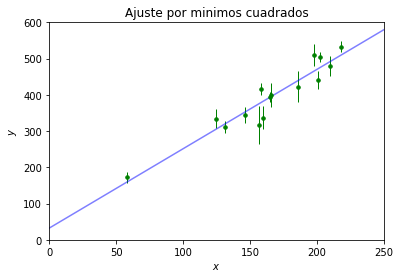

In [208]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline 
import corner

# Datos que ajustaremos
#  x, y, sigma_y
datos = np.array([[201,592,61],[244,401,25],[47,583,38],[287,402,15],[203,495,21],
                  [58,173,15],[210,479,27],[202,504,14],[198,510,30],[158,416,16],
                  [165,393,14],[201,442,25],[157,317,52],[131,311,16],[166,400,34],
                  [160,337,31],[186,423,42],[125,334,26],[218,533,16],[146,344,22]])

# Limites de las graficas
xlimits = [0,250]
ylimits = [0,600]
title_prefix = 'Problem set 1'
plot_format = '.png'

def get_data():
    # Obtener datos de x, y, sigma_y que agrupamos en datos
    x = datos[5:,0]
    y = datos[5:,1]
    sigmay = datos[5:,2]
    return (x, y, sigmay)

# Funcion para graficar las barras de error de los datos
def plot_yerr(x, y, sigmay):
    plt.errorbar(x, y, yerr=sigmay, fmt='.', ms=7, lw=1, color='g')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    plt.title(title_prefix)

# Modelo lineal   y = mx + b.
def plot_line(b, m, **kwargs):
    x = np.array(xlimits)
    y = m*x + b
    p = plt.plot(x, y, 'b-', alpha=0.5, **kwargs)
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    return p

# Método de minimos cuadrados, regresa los mejores valores (m, b)
def leastsq(x, y):
    print 'Ajuste usando minimos cuadrados'
    # numero depuntos
    N = len(x)
    # construyendo matriz
    X = np.zeros((N,2))
    X[:,0] = 1.
    X[:,1] = x
    #print 'X shape:', X.shape
    XTX = np.dot(X.T, X)
    #print 'XTX shape:', XTX.shape
    XTy = np.dot(X.T, y)
    #print 'XTy shape:', XTy.shape
    beta = np.dot(np.linalg.inv(XTX), XTy)
    print 'b,m =', beta
    (m, b) = beta
    print
    return (m, b)

# A continuacion se presentan un primer analisis de los datos

(x, y, sigmay) = get_data() 

# Graficar los puntos 
plot_yerr(x, y, sigmay)
# save just the data points plot \\plt.savefig('p1-data' + plot_format)

# Solucion de m y b con minimos cuadrados ignorando el error de y.
(m, b) = leastsq(x, y)
plot_line(m, b)
plt.title('Ajuste por minimos cuadrados')


def pruebalikehood():
    (x, y, sigmay) = get_data()
    (m,b) = (2.2, 30)
    print 'Likelihood at', (m,b), 'is', straight_line_gaussian_likelihood(x, y, sigmay, m, b)
    print 'Log-likelihood at', (m,b), 'is', straight_line_gaussian_loglikelihood(x, y, sigmay, m, b)

## Generalizacion del algoritmo MCMC para varios caminadores

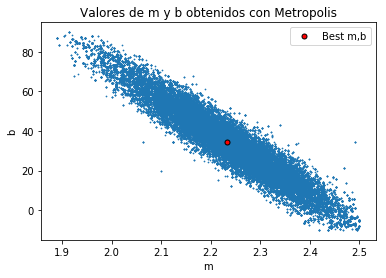

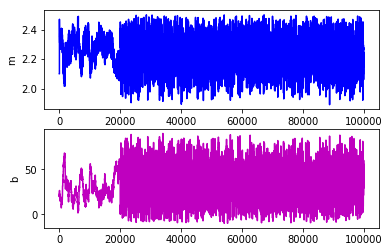

In [210]:
# Definimos la funcion likehood gaussiana para una linea
def straight_line_gaussian_likelihood(x, y, sigmay, m, b):
    return np.prod(1./(np.sqrt(2.*np.pi) * sigmay) * np.exp(-(y - (m * x + b))**2 / (2. * sigmay**2)))

# Definimos el prior
def prior(m,b):
    if ((0 < m <2.5) and (-10 < b < 90)):
        return 0.
    else:
        return -np.infty
    return 

# Valores iniciales para m y b, son valores propuestos
m = 2.1
b = 20
# Tamaño de los pasos (sigmas)
step_m = 0.5
step_b = 2.

# Numero de cadenas
nchains = 10 

# Numero de cadenas
steps = 10000

    
# Obtener los datos
(x, y, sigmay) = get_data()


# En chain y probs se guardaran todos los datos de m,b y likehood para las m cadenas de n pasos
chain = []
probs = []

for j in range(nchains):
    if (j==0): # Si es la primera cadena iniciamos con m y b definidos arriba
        m_start = m
        b_start = b
    elif (j==1):
        # Despues de haber hecho una cadena obtenemos los mejores valores de m y b con la probabilidad maxima
        mm = [m for m,b in chain]
        bb = [b for m,b in chain]
        
        # Obteniendo los mejores valores de m, b cnon la probabilidad
        besti = np.argmax(probs)
        bestm = mm[besti]
        bestb = bb[besti]
        
        # Despues de la primera cadena redefinimos los sigmas con la desviacione standar de la primera cadena 
        # y obtenemos valores random normales para m y b
    elif (j>=1):
        step_m = 2*np.std(mm)
        step_b = 2*np.std(bb)
        m_start = np.random.normal(bestm,step_m)
        b_start = np.random.normal(bestb,step_m)
        
    for i in range(steps):
        # Obteniendo un valor aleatorio normalizado de m y b
        mnew = np.random.normal(m_start,step_m)
        bnew = np.random.normal(b_start,step_b)
        
        # Evaluando la probabilidad con los nuevos m y b
        prob_new = straight_line_gaussian_likelihood(x, y, sigmay, mnew, bnew)
        # Evaluando probabilidad de m y b iniciales
        prob_old = straight_line_gaussian_likelihood(x, y, sigmay, m_start, b_start)
        
        lnprior = prior(mnew,bnew) # Obteniendo valor de prior para los m y b nuevos
        
        # Realizamos un primer filtro de los datos poner un pr igual a lo que viene del prior 
        # y en donde calculo prob_new  igual al prob_new mas el prior
        # checar que si el prior es infinito entonces se salga
        if (lnprior == 0.):
            prob_new = prob_new 
        else:
            prob_new = prob_new + lnprior
            
        # Comparando las probabilidades para decidir cuales valores de m aceptar 
        if (prob_new/prob_old > 1):
            m_start = mnew
            b_start = bnew
            prob = prob_new
        else:
            prob_test = np.random.uniform(0,1)
            if (prob_test> prob_new/prob_old):
                prob = prob_old
            else:
                m_start = mnew
                b_start = bnew
                prob = prob_new
                
        # Guardando los valores de m y b
        chain.append((m_start,b_start))
        # Guardando el valor de la probabilidad (likehood)
        probs.append(prob)

# Estos vectores contienen todos los m y b de todas las cadenas
mm = [m for m,b in chain]
bb = [b for m,b in chain]

# Obteniendo los mejores valores de m, b cnon la probabilidad
besti = np.argmax(probs)
bestm = mm[besti]
bestb = bb[besti]
    
# Graficando los valores de m y b
plt.scatter(mm, bb, s=3, lw = 0)

# Mejor valor obtenido de m y b
plt.plot(bestm, bestb, 'ko', label='Best m,b',markersize=5, markerfacecolor='r')
plt.xlabel('m')
plt.ylabel('b')
plt.title('Valores de m y b obtenidos con Metropolis')
plt.legend()
plt.show()

plt.clf()
plt.title('Graficas de muestreo para las cadenas consecutivas')
plt.subplot(2,1,1)
plt.plot(mm, 'b-')
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'm-')
plt.ylabel('b')
plt.show()

## Presentamos el histograma de los datos m y b, así como el nuevo ajuste usando corner

('Mejor m', 2.2317309657924)
('Mejor b', 34.980162585560514)


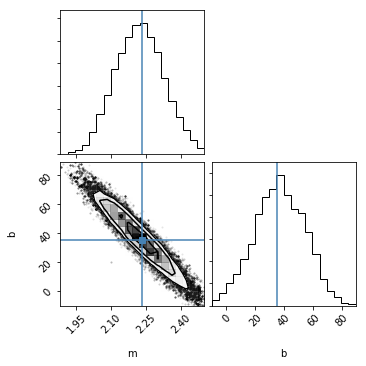

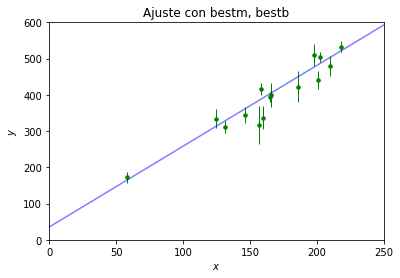

In [20]:
#  Definiendo curva gaussiana
print("Mejor m", bestm)
print("Mejor b", bestb)
    
#graficando con triangle (corner)
plt.clf()
corner.corner(chain, labels=['m', 'b'],
                truths=[bestm, bestb])
#plt.savefig('p3-tri.png')
    
    
#Ploteando la linea con los mejores valores
plt.figure()
plot_yerr(x, y, sigmay)
plot_line(bestb, bestm)
plt.title('Ajuste con bestm, bestb')
plt.show()    

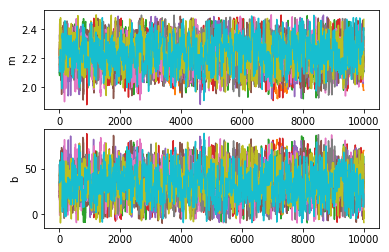

In [91]:
def valores(i):
    ms = mm[10000*i:10000*(i+1)]
    bs = bb[10000*i:10000*(i+1)]
    return ms,bs
# Se presentan los datos para m y b de cada cadena en forma paralela

plt.subplot(2,1,1)
plt.ylabel('m')
for i in range(nchains):
    plt.plot(mm[10000*i:10000*(i+1)])

plt.subplot(2,1,2)
plt.ylabel('b')
for i in range(nchains):
    plt.plot(bb[10000*i:10000*(i+1)])


## Muestreo para cada cadena de forma simultanea

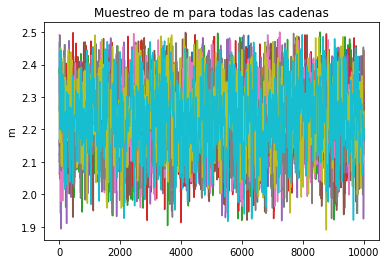

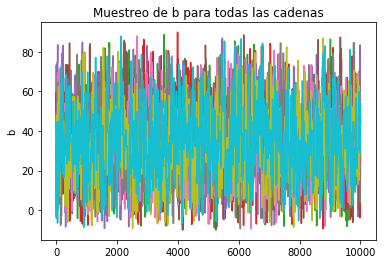

In [213]:
# Definimos una funcion para extraer los datos de cada cadena
def chain_data(i):
    ms = mm[steps*i:steps*(i+1)]
    bs = bb[steps*i:steps*(i+1)]
    return ms,bs

plt.ylabel('m')
plt.title('Muestreo de m para todas las cadenas')
for i in range(nchains):
    plt.plot(chain_data(i)[0])
plt.show()

plt.clf()
plt.ylabel('b')
plt.title('Muestreo de b para todas las cadenas')
for i in range(nchains):
    plt.plot(chain_data(i)[1])
plt.show()

## Prueba de convergencia usando diagnóstico Gelman y Rubin

In [215]:
# Definimos la funcion de diagnostico Gelman y Rubin, dependera del parametro theta.
# Para una buena convergencia debemos obtener R cercano a 1
def gelman_rubin(theta):
    var = [] 
    theta_chains = []
    for i in range(nchains):
        var.append(np.var(chain_data(i)[theta]))
        theta_chains.append(np.mean(chain_data(i)[theta]))
    W = np.mean(var)
    theta_prom = np.mean(theta_chains)
    m = nchains
    n = steps
    B = (n / (m - 1)) * np.sum((theta_chains - theta_prom)**2)
    var_theta = (1-(1/n)) * W + 1 / n * B
    R = np.sqrt(var_theta / W) # Potential scale reduction factor
    return R
    

In [216]:
# Para este modelo los parametros corresponden a m = 0 y b = 1

print 'Realizando prueba de convergencia'
print 'El factor potencial de reduccion de m es: ', gelman_rubin(0)
print 'El factor potencial de reduccion de m es: ', gelman_rubin(1)

Realizando prueba de convergencia
El factor potencial de reduccion de m es:  1.0
El factor potencial de reduccion de m es:  1.0


In [207]:
var = [] 
theta_chains = []
for i in range(nchains):
    var.append(np.var(chain_data(i)[0]))
    theta_chains.append(np.mean(chain_data(i)[0]))
W = np.mean(var)
theta_prom = np.mean(theta_chains)
print 'W', W
print 'thetaprom', theta_prom
B = n / (m - 1) * np.sum((theta_chains - theta_prom)**2)
print 'B',B
var_theta = (1-(1/n)) * W + 1 / n * B
print 'vartheta',var_theta
np.sqrt(var_theta/W)

W 0.0100625585232
thetaprom 2.2209839233
B 0.102418068978
vartheta 0.0100625585232


1.0

In [206]:
gelman_rubin(0)

1.0

In [184]:
theta_prom

2.220983923296334

In [154]:
np.var(chain_data(0)[0])

0.0042489842928047396

In [140]:
def gelman_rubin(chain): 
    ssq = np.var(chain,axis=0)
    W = np.mean(ssq, axis=0)
    thetab = np.mean(chain, axis=1)
    thetabb = np.mean(thetab, axis=0)
    m = nchains
    n = steps
    B = n / (m - 1) * np.sum((thetabb - thetab)**2, axis=0)
    var_theta = (n - 1) / n * W + 1 / n * B
    R = np.sqrt(var_theta / W)
    return R,ssq

In [141]:
np.var(chain_data(0)[1])

112.46513877992143

In [142]:
np.var(chain_data(0),axis=0)

array([  80.1025    ,   80.1025    ,   80.1025    , ...,  220.26622807,
        220.26622807,  220.26622807])